In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(repr)
library(GGally)
install.packages("kknn")
library(kknn)
set.seed(999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### Using Cholesterol, Fasting Blood Sugar, and Age to Classify Heart Disease Patients from Cleveland
**Introduction**  

Heart (cardiovascular) disease is a term displaying the wide range of heart conditions directly affecting the heart, associated blood vessels, and muscles surrounding the heart (Heart and Stroke Foundation Canada, n.d.). Such effects can result in long-term or short-term effects on the function of the heart itself, spreading to other internal organs. Amongst the range of “heart” diseases, coronary artery disease, commonly found in the United States, is where the patients' blood vessels are narrowed and constricts the amount of blood supplying the heart. There is a multitude of prospective factors that may influence the likelihood of developing coronary artery disease or any variant of cardiovascular disease, including but not limited to, fasting blood sugar, cholesterol, and age.

Increased intake of cholesterol can build up inside of the blood vessels and restrict the flow to the heart, brain, lungs and kidneys (Centers for Disease Prevention and Control, 2022). Similarly, studies have observed and indicated fasting blood sugar as an underlying predictor of heart disease and the effects on the heart (National Library of Medicine, 2013). Additionally, the heart is considered a muscle and therefore weakens within aging. Older hearts rest at lower heart rates, which can lead to build up against the lining of the arteries, preventing blood pressure stabilization (Swiner, 2023).

The objective of this project is to classify and categorize patients on their potential risk in developing heart disease.  

The question we will be addressing is: **What is the likelihood of a patient at risk for heart disease based on their cholesterol, fasting blood sugar, and age?**

In [2]:
heart_data <- read_csv("https://raw.githubusercontent.com/fellasleep2324/dsci-100-2023-24-grp12/main/heart.csv") 

heart_rename <- heart_data  |>
    rename(heart_disease = target, # presence of heart disease
           max_heartrate = thalach, # maximum heartreate achieved
           resting_bp = trestbps, # resting blood pressure on admittance to hospial
           st_depression = oldpeak) |> # EKG ST depression. A depression between the "S" and "T" lines on an EKG. Considered to be a
                                       # good indicator of heart conditions (Reference: Kashou AH, Basit H, Malik A. ST Segment. [Updated 2023 Aug 14]. 
                                                                                      # In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 
                                                                                      # 2023 Jan. Available from: https://www.ncbi.nlm.nih.gov/books/NBK459364/  
    mutate(heart_disease = as_factor(heart_disease)) |>
    mutate(heart_disease = fct_recode(heart_disease, "Yes" = "1", "No" = "0"))
    
heart_tidy <- heart_rename |>
    select(age, resting_bp, chol, max_heartrate,st_depression, heart_disease)
head(heart_tidy)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age resting_bp chol max_heartrate st_depression heart_disease
1 52  125        212  168           1.0           No           
2 53  140        203  155           3.1           No           
3 70  145        174  125           2.6           No           
4 61  148        203  161           0.0           No           
5 62  138        294  106           1.9           No           
6 58  100        248  122           1.0           Yes

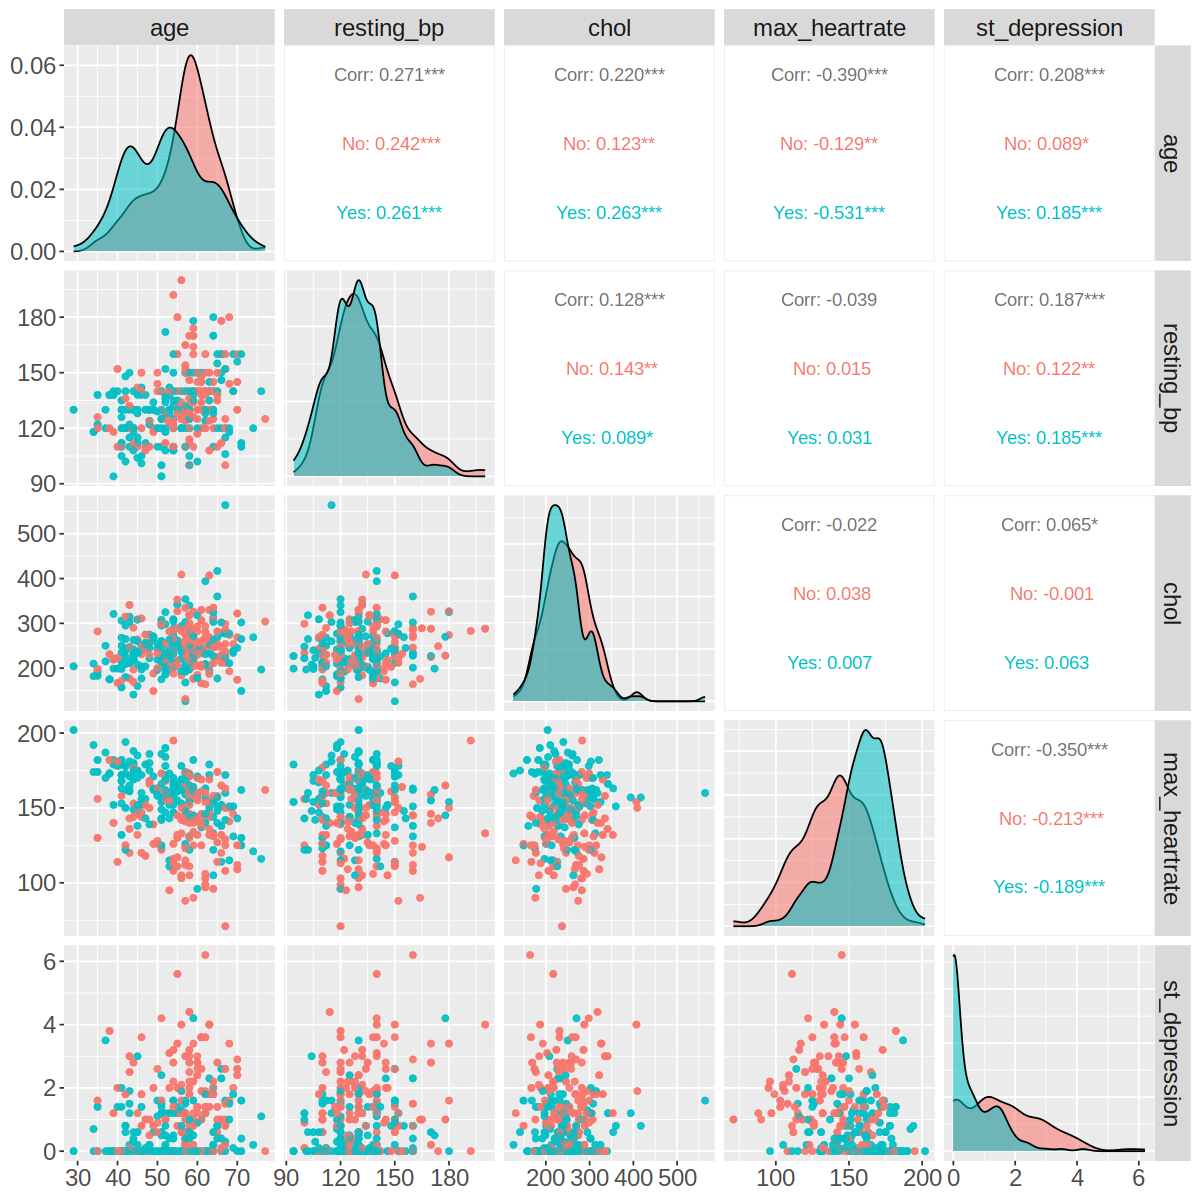

In [3]:
options(repr.plot.width = 10, repr.plot.height = 10)

heart_initial_compare <- heart_tidy |>
    ggpairs(aes(alpha = 0.5, color = heart_disease),
           columns = 1:5) +
    theme(text = element_text(size = 18))

heart_initial_compare

Then the tidy data is split into training and testing data sets. The percentage of total rows from heart_data has also been calculated using the training_heart set to confirm a correct splitting ratio.

In [6]:
heart_tidy_split <- initial_split(heart_tidy, prop = 0.75, strata = heart_disease)
training_heart <- training(heart_tidy_split)
testing_heart <- testing(heart_tidy_split)

split_percent <- round(nrow(training_heart)/ (nrow(training_heart) + nrow(testing_heart)) * 100)

split_percent

[1] 75

In [7]:
# All three data sets, heart_data, training_heart and testing_heart are summarized and the 
# ratio of positive and negative values for the heart_disease column are calculated and
# returned to ensure the split data sets are consistent with the original tidy data. 

num_obs_heart = nrow(heart_tidy)
num_obs_training = nrow(training_heart)
num_obs_testing = nrow(testing_heart)

heart_data_percent <- heart_tidy |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_total = round(n() / num_obs_heart * 100, 2))

training_heart_percent <- training_heart |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_training = round(n() / num_obs_training * 100, 2))

testing_heart_percent <- testing_heart |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_testing = round(n() / num_obs_testing * 100, 2))

heart_data_percent
training_heart_percent
testing_heart_percent

heart_disease total percentage_total
1 No            499   48.68           
2 Yes           526   51.32

heart_disease total percentage_training
1 No            374   48.7               
2 Yes           394   51.3

heart_disease total percentage_testing
1 No            125   48.64             
2 Yes           132   51.36

In [8]:
# tuning the k value based on the above ggpairs plot using all the columns selected as predictors
# performing a 5 fold cross-validation

heart_vfold <- vfold_cv(training_heart, v = 15, strata = heart_disease) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_recipe <- recipe(heart_disease ~ ., 
                       data = training_heart) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = heart_vfold) |>
    collect_metrics()

knn_fit

.metric  .estimator mean      n  std_err     .config             
1 accuracy binary     0.8801599 15 0.010460158 Preprocessor1_Model1
2 roc_auc  binary     0.9478913 15 0.005915956 Preprocessor1_Model1

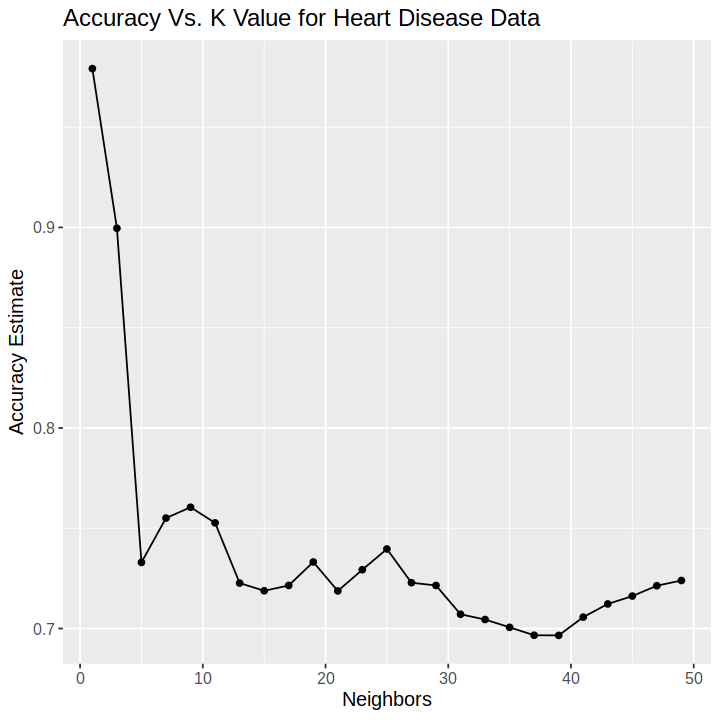

In [9]:
# tuning the k value based on the above ggpairs plot using all the columns selected as predictors
# performing the k value tuning.
options(repr.plot.width = 6, repr.plot.height = 6)

heart_vfold <- vfold_cv(training_heart, v = 15, strata = heart_disease) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_recipe <- recipe(heart_disease ~ ., 
                       data = training_heart) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

heart_knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = heart_k_vals) |>
    collect_metrics()

heart_accuracies <- heart_knn_results |>
    filter(.metric == "accuracy")

acc_vs_k_plot <- heart_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line () +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Accuracy Vs. K Value for Heart Disease Data") +
        theme(text = element_text(size = 12))

acc_vs_k_plot

In [14]:
# based on the data above, the best choice for k is 1.
# we will now run the knn classifier with a k value of 1 and show the accuracy and confusion matrix.

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_recipe <- recipe(heart_disease ~ ., 
                       data = training_heart) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = training_heart)

heart_test_predictions <- predict(knn_fit, testing_heart) |>
    bind_cols(testing_heart)

heart_acc_3 <- metrics(data = heart_test_predictions, truth = heart_disease, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull() |>
    round(digits = 2)

heart_confusion <- heart_test_predictions |>
    conf_mat(truth = heart_disease, estimate = .pred_class)

# displaying the accuracy metric and connfusion matrix for k = 3.
heart_acc_3 
heart_confusion

[1] 0.99

          Truth
Prediction  No Yes
       No  122   0
       Yes   3 132

**Methods**  
We will analyze our data with the K – nearest neighbors classification algorithm, which predicts new observations given the K number of nearest neighbors and the category predictors. We will use cholesterol, fasting blood sugar, and age as our predictor variables to classify whether the patient is susceptible to heart disease (reasons stated in introduction). We will perform cross-validation, where the overall training dataset is split into a validation and training set, to estimate the current data’s ability to predict unseen data. Cross-validation is important because we can estimate using our available data, meaning no new patient observations are required, and it helps determine the value of K that reduces under/overfitting. Furthermore, we will investigate the classifiers performance based on its accuracy, precision, and recall to conclude if the classifier is useful.

The points on the scatterplot will be colored according to the classification category. New data will be colored a different color from the categories to help recognize that it is unseen data and its nearest neighbors. 

**Expected Outcomes and Significance**  

Our expectation is that individuals who have been diagnosed with heart disease will, on average, exhibit higher levels of cholesterol, have low fasting blood sugar and tend to be older in age.  

Creating a K - nearest neighbors classification system for heart disease can simplify and improve the accuracy of diagnosis by health care professionals. This can ultimately lead to timely intervention and treatment.